In [31]:
!pip install recnn
!pip install torch_optimizer
!pip install tensorboard
!pip install sklearn
!pip install jupyterthemes

In [46]:
from collections import namedtuple, deque
import misc
import torch
import pickle
import os
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch_optimizer as optim
import pickle
import numpy as np
from collections import namedtuple
import sys
from jupyterthemes import jtplot
jtplot.style(theme='grade3')
sys.path.append("../../")


In [47]:
def get_tensor(x, y, z):
    multiply_tensor = torch.zeros((x * z, y * z, x * y), dtype=torch.float32)

    for i in range(z):
        for j in range(x):
            for k in range(y):
                multiply_tensor[i * x + j][i * y + k][j + k * x] = 1

    final_tensor = torch.tensor(multiply_tensor)
    return final_tensor

In [48]:
lib = {}
for a in range(1, 10):
    for b in range(1, 10):
        for c in range(1, 10):
            lib.update({(a, b, c): get_tensor(a, b, c)})

with open('tensor_holder\\tensors', 'wb') as f:
        pickle.dump(lib, f)

/var/folders/y7/7g_7wfqd5hj9qmks2g8q5l200000gn/T/ipykernel_49000/2081598127.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_tensor = torch.tensor(multiply_tensor)
/var/folders/y7/7g_7wfqd5hj9qmks2g8q5l200000gn/T/ipykernel_49000/2081598127.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_tensor = torch.tensor(multiply_tensor)


In [49]:
%matplotlib inline


cuda = torch.device('cpu')

# ---
frame_size = 10
batch_size = 25
n_epochs   = 100
plot_every = 30
step       = 0
# ---

tqdm.pandas()

with open('tensor_holder\\tensors', 'rb') as f:
    multiply_tensors = pickle.load(f)

In [50]:
class Environment:
    def __init__(self, shape):
        self.shape = shape
        self.m = self.shape[0]
        self.n = self.shape[1]
        self.d = self.shape[2]
        self.state = None

    def reset(self):
        self.state = torch.clone(multiply_tensors[self.shape]).to(torch.float32)
        return self.state

    def step(self, action):
        # Perform action on the environment
        # Update the state based on the action
        # Compute the reward and done flag
        summ = torch.outer(torch.tensor(action[0]), torch.tensor(action[1]))
        for j in range(4):
            self.state[j] -= summ * torch.tensor(action[2], dtype=torch.float32)

        # Example: Compute reward and done flag
        reward = -1
        done = torch.equal(self.state, torch.zeros(self.m * self.n, self.n * self.d, self.m * self.d))

        return self.state, reward, done

In [51]:
class BatchBuffer:
  def __init__(self, memory_size=1000):
    self.memory_size = memory_size
    self.Buffer = namedtuple('Buffer', 'state action reward next_state done')
    self.replay_memory = deque(maxlen=memory_size)

  def get_batch(self): # to change
    rand_ind = np.random.choice(len(self.replay_memory))
    return self.replay_memory[rand_ind]

  def append(self, state, action, reward, next_state, done):
    self.replay_memory.append(self.Buffer(state, action, reward, next_state, done))

  def append_batch(self, state_batch, action_batch, reward_batch, next_state_batch, done):
    for i in range(state_batch.shape[0]):
      self.append(state_batch[i], action_batch[i], reward_batch[i], next_state_batch[i], done)

  def clear(self):
    self.replay_memory.clear()

  def print_len_buffer(self):
    return len(self.replay_memory)

env_shape = (2, 2, 2)
env = Environment(env_shape)

In [52]:
class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-1):
        super(Actor, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)

        self.linear1 = nn.Linear(input_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_dim)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
        # state = self.state_rep(state)
        x = F.tanh(self.linear1(state))
        x = self.drop_layer(x)
        x = F.tanh(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = torch.tanh(self.linear3(x)) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x # action

In [53]:
class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)

        self.linear1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=0)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [54]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )


In [55]:
def ddpg_update(step_batch, params, learn=True, step=-1):

    state, action, reward, next_state, done = step_batch

    # --------------------------------------------------------#
    # Value Learning

    with torch.no_grad():
        next_action = torch.Tensor(select_action(next_state, target_policy_net))
        target_value   = target_value_net(next_state.resize(64), next_action.detach().resize(12))
        expected_value = reward + (1.0 - done) * params['gamma'] * target_value
        expected_value = torch.clamp(expected_value,
                                     params['min_value'], params['max_value'])

    value = value_net(state.resize(64), torch.Tensor(action).resize(12))

    value_loss = torch.pow(value - expected_value.detach(), 2).mean()

    if learn:
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
    else:
        debug['next_action'] = next_action
        writer.add_figure('next_action',
                    misc.pairwise_distances_fig(next_action[:50]), step)
        writer.add_histogram('value', value, step)
        writer.add_histogram('target_value', target_value, step)
        writer.add_histogram('expected_value', expected_value, step)

    # --------------------------------------------------------#
    # Policy learning

    gen_action = select_action(state, policy_net)
    policy_loss = -value_net(state.resize(64), torch.from_numpy(gen_action).resize(12))

    if not learn:
        debug['gen_action'] = gen_action
        writer.add_histogram('policy_loss', policy_loss, step)
        writer.add_figure('next_action',
                    misc.pairwise_distances_fig(gen_action[:50]), step)

    policy_loss = policy_loss.mean()

    if learn and step % params['policy_step']== 0:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net, target_value_net, soft_tau=params['soft_tau'])
        soft_update(policy_net, target_policy_net, soft_tau=params['soft_tau'])


    losses = {'value': value_loss.item(), 'policy': policy_loss.item(), 'step': step}
    misc.write_losses(writer, losses, kind='train' if learn else 'test')
    return losses

# === ddpg settings ===

params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 10,
    'soft_tau'   : 0.001,
    'max_steps'  : 8,
    'policy_lr'  : 1e-5,
    'value_lr'   : 1e-5,
    'actor_weight_init': 54e-2,
    'critic_weight_init': 6e-1,
}

# === end ===


In [56]:
value_net  = Critic(64, 12, 128, params['critic_weight_init']).to(cuda)
policy_net = Actor(64, 12, 128, params['actor_weight_init']).to(cuda)


target_value_net = Critic(64, 12, 128).to(cuda)
target_policy_net = Actor(64, 12, 128).to(cuda)


target_policy_net.eval()
target_value_net.eval()

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = nn.MSELoss()

# from good to bad: Ranger Radam Adam RMSprop
value_optimizer = optim.Ranger(value_net.parameters(),
                              lr=params['value_lr'], weight_decay=1e-2)
policy_optimizer = optim.Ranger(policy_net.parameters(),
                               lr=params['policy_lr'], weight_decay=1e-5)

loss = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

debug = {}

writer = SummaryWriter(log_dir='../../runs')
plotter = misc.Plotter(loss, [['value', 'policy']],)

In [57]:
def select_action(state, actor):
        state = torch.tensor(state, dtype=torch.float32).view(1, -1)
        action = actor(state).detach().numpy()[0]
        action = np.array(tuple(map(lambda el: max((-1 if -1<=el<-0.33 else 0, 1 if 0.33<el<=1 else 0), key=abs), action))).reshape(3, 4)
        return action

act = select_action(env.reset(), policy_net)

In [58]:
buffer = BatchBuffer()
env = Environment(env_shape)

num_episodes = 100

for i in range(num_episodes):
  state = env.reset()
  done = False
  episode_reward = 0
  steps = 0

  while not done:
    if steps == params['max_steps']:
      episode_reward -= params['max_steps']
      buffer.append(state, action, episode_reward, next_state, done)
      break
    action = select_action(state, policy_net)
    next_state, reward, done = env.step(action)
    episode_reward += reward

    buffer.append(state, action, episode_reward, next_state, done)

    state = torch.clone(next_state)
    steps += 1

/var/folders/y7/7g_7wfqd5hj9qmks2g8q5l200000gn/T/ipykernel_49000/3093035418.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).view(1, -1)
/var/folders/y7/7g_7wfqd5hj9qmks2g8q5l200000gn/T/ipykernel_49000/3093035418.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).view(1, -1)


/var/folders/y7/7g_7wfqd5hj9qmks2g8q5l200000gn/T/ipykernel_49000/3093035418.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).view(1, -1)
/Users/artemvolosevich/Documents/JetProjects/PyProjects/DPR-Matrix-Multiplication/venv/lib/python3.11/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


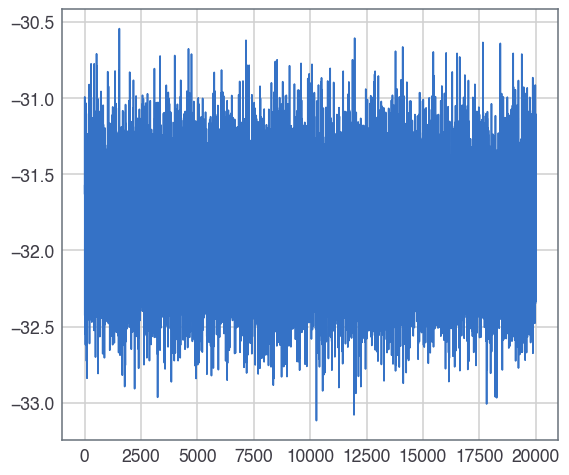

In [59]:

batch = buffer.get_batch()
ddpg_update(batch, params)
